In [108]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
conn_str = os.environ["DB_WAREHOUSE_URI"]
read_sql_query = lambda sql: pd.read_sql_query(sql, conn_str)

# Scheduled loads

### All scheduled loads

In [110]:
query = """
SELECT *
FROM "factScheduledLoads"
"""
read_sql_query(query)

,Customer,CustomerCode,PONumber,PODate,ShippingNumber,LoadPieces,LoadTons
0,Trebor Inventory,282304,691306/13121,2024-11-11,71467.0,9.0,19.691
1,Trebor Inventory,282304,691306/13121,2024-11-11,71477.0,9.0,19.776
2,Trebor Inventory,282304,691306/13121,2024-11-11,71478.0,9.0,19.944
3,Trebor Inventory,282326,691307/13122,2024-11-11,71557.0,36.0,19.666


### Q 100: How many loads are scheduled for PO # x?

#### Example: How many loads are scheduled for PO 691306/13121?

In [111]:
PONumber = "691306/13121"  # Update this to the PONumber you want to query

query = """
SELECT "PONumber", SUM("LoadPieces") AS "TotalPieces", SUM("LoadTons") AS "TotalTons"
FROM "factScheduledLoads"
WHERE "PONumber" = '{PONumber}'
GROUP BY "PONumber"
""".format(PONumber=PONumber)
read_sql_query(query)

,PONumber,TotalPieces,TotalTons
0,691306/13121,27.0,59.411


### Q 101: How many loads are scheduled for customer code x?

#### Example: How many loads are scheduled for Customer Code 282304?

In [112]:
CustomerCode = "282304"  # Update this to the PONumber you want to query

query = """
SELECT "CustomerCode", SUM("LoadPieces") AS "TotalPieces", SUM("LoadTons") AS "TotalTons"
FROM "factScheduledLoads"
WHERE "CustomerCode" = '{CustomerCode}'
GROUP BY "CustomerCode"
""".format(CustomerCode=CustomerCode)
read_sql_query(query)

,CustomerCode,TotalPieces,TotalTons
0,282304,27.0,59.411


### Q 25: Show the loads scheduled, by referencing pick up number with PO#

In [113]:
query = """
SELECT "PONumber", "ShippingNumber", "LoadPieces", "LoadTons"
FROM "factScheduledLoads"
"""
read_sql_query(query)

,PONumber,ShippingNumber,LoadPieces,LoadTons
0,691306/13121,71467.0,9.0,19.691
1,691306/13121,71477.0,9.0,19.776
2,691306/13121,71478.0,9.0,19.944
3,691307/13122,71557.0,36.0,19.666


### Q 26: Show the loads scheduled, by customer code

In [114]:
query = """
SELECT "CustomerCode", SUM("LoadPieces") AS "TotalPieces", SUM("LoadTons") AS "TotalTons"
FROM "factScheduledLoads"
GROUP BY "CustomerCode"
"""
read_sql_query(query)

,CustomerCode,TotalPieces,TotalTons
0,282304,27.0,59.411
1,282326,36.0,19.666


### Q 94: Show me the PO's with open pick up/shipper #'s

In [115]:
query = """
SELECT "PONumber", SUM("LoadPieces") AS "TotalPieces", SUM("LoadTons") AS "TotalTons"
FROM "factScheduledLoads"
GROUP BY "PONumber"
"""
read_sql_query(query)

,PONumber,TotalPieces,TotalTons
0,691306/13121,27.0,59.411
1,691307/13122,36.0,19.666


### Q 98: Show me the PO's with open pick up/shipper #'s for these customer codes

In [116]:
customer_codes = ['282326', '282304']
query = """
SELECT "PONumber", "CustomerCode", SUM("LoadPieces") AS "TotalPieces", SUM("LoadTons") AS "TotalTons"
FROM "factScheduledLoads"
WHERE "CustomerCode" IN ({customer_codes})
GROUP BY "PONumber", "CustomerCode"
""".format(customer_codes=', '.join([f"'{code}'" for code in customer_codes]))
read_sql_query(query)

,PONumber,CustomerCode,TotalPieces,TotalTons
0,691306/13121,282304,27.0,59.411
1,691307/13122,282326,36.0,19.666


# Old inventory (non-shipped rolls)

### Q 22: Show the rolls, by customer code, that are 6 months to 1 year

In [117]:
start = (pd.Timestamp.now() - pd.DateOffset(months=12)).date()
end = (pd.Timestamp.now() - pd.DateOffset(months=6)).date()

query = """
SELECT *
FROM "factInventoryNotShipped"
WHERE "DateEntered" BETWEEN '{start}' AND '{end}'
ORDER BY "DateEntered"
""".format(start=start, end=end)
read_sql_query(query).head(10)

,RollID,WrapperNumber,DateEntered,TimeEntered,DateTimeEntered,RollNumber,SetPosition,GradeCode,CustomerGradeCode,Shift,...,RedPO,LabelPrinted,Breaks,NextSet,SlabDate,Workstation,LabelInitials,SCABarcode,SCAGrade,BayLocation
0,R5-23-09557B,WR5,2023-12-09,1899-12-30 18:51:00,2023-12-09 18:51:45,9557,B,125-98-1-090,282326,Night,...,None,-1,NaN,C,None,STT-CUCONWRAPPE,AB,None,None,None
1,R5-23-09556B,WR5,2023-12-09,1899-12-30 18:51:00,2023-12-09 18:51:48,9556,B,125-98-1-090,282326,Night,...,None,-1,1.0,C,None,STT-CUCONWRAPPE,AB,None,None,None
2,R5-23-09543C,WR5,2023-12-09,1899-12-30 07:59:00,2023-12-09 07:59:14,9543,C,125-98-1-090,282304,Day,...,None,-1,NaN,D,None,STT-CUCONWRAPPE,MW,None,None,None
3,R5-23-09615A,WR5,2023-12-11,1899-12-30 05:50:00,2023-12-12 05:50:56,9615,A,125-98-1-090,282326,Night,...,None,-1,2.0,B,12/14/2023,STT-CUCONWRAPPE,TC,None,None,None
4,R5-23-09607A,WR5,2023-12-11,1899-12-30 21:27:00,2023-12-11 21:27:48,9607,A,125-98-1-090,282326,Night,...,None,-1,NaN,B,12/14/2023,STT-CUCONWRAPPE,TC,None,None,None
5,R5-23-09661A,WR5,2023-12-14,1899-12-30 02:52:00,2023-12-15 02:52:55,9661,A,125-98-1-090,282326,Night,...,None,-1,NaN,B,12/20/2023,STT-CUCONWRAPPE,MW,None,None,None
6,R5-23-09666A,WR5,2023-12-14,1899-12-30 02:57:00,2023-12-15 02:57:33,9666,A,125-98-1-090,959126,Night,...,None,-1,NaN,B,12/20/2023,STT-CUCONWRAPPE,MW,None,756807,None
7,R5-23-09664A,WR5,2023-12-14,1899-12-30 02:57:00,2023-12-15 02:57:25,9664,A,125-98-1-090,282326,Night,...,None,-1,NaN,B,12/20/2023,STT-CUCONWRAPPE,MW,None,None,None
8,R5-23-09663A,WR5,2023-12-14,1899-12-30 02:55:00,2023-12-15 02:55:57,9663,A,125-98-1-090,282326,Night,...,None,-1,NaN,B,12/20/2023,STT-CUCONWRAPPE,MW,None,None,None
9,R6-23-10855A,WR6,2023-12-15,1899-12-30 03:38:00,2023-12-16 03:38:13,10855,A,125-98-1-101,671214,Night,...,None,-1,NaN,B,1/22/2024,STT-WRAPPER6,eb,None,None,None


### Q 23: Show the rolls, by customer code, that are 1-2 years old

In [118]:
start = (pd.Timestamp.now() - pd.DateOffset(months=24)).date()
end = (pd.Timestamp.now() - pd.DateOffset(months=12)).date()

query = """
SELECT *
FROM "factInventoryNotShipped"
WHERE "DateEntered" BETWEEN '{start}' AND '{end}'
ORDER BY "DateEntered"
""".format(start=start, end=end)
read_sql_query(query).head(10)

,RollID,WrapperNumber,DateEntered,TimeEntered,DateTimeEntered,RollNumber,SetPosition,GradeCode,CustomerGradeCode,Shift,...,RedPO,LabelPrinted,Breaks,NextSet,SlabDate,Workstation,LabelInitials,SCABarcode,SCAGrade,BayLocation
0,R6-22-13384B,WR6,2022-12-11,1899-12-30 05:15:00,2022-12-12 05:15:56,13384,B,190-98-3-110,971900,Night,...,None,-1,1.0,C,None,STT-WRAPPER6,WJ,None,None,None
1,R5-22-09274A,WR5,2022-12-11,1899-12-30 00:30:00,2022-12-12 00:30:46,9274,A,125-98-1-090,289999,Night,...,None,-1,NaN,B,12/11/2022,STT-CUCONWRAPPE,TC,None,None,None
2,R6-22-13576A,WR6,2022-12-16,1899-12-30 21:38:00,2022-12-16 21:38:52,13576,A,200-98-3-100,532002,Night,...,None,-1,NaN,B,None,STT-WRAPPER6,AE,None,None,None
3,R5-22-09411A,WR5,2022-12-16,1899-12-30 19:43:00,2022-12-16 19:43:32,9411,A,125-98-1-090,959999,Night,...,None,-1,NaN,B,12/16/2022,STT-CUCONWRAPPE,JL,None,756088,None
4,R5-22-09410C,WR5,2022-12-16,1899-12-30 19:41:00,2022-12-16 19:41:43,9410,C,125-98-1-090,959999,Night,...,None,-1,NaN,D,12/16/2022,STT-CUCONWRAPPE,JL,None,756088,None
5,R5-22-09429B,WR5,2022-12-17,1899-12-30 10:59:00,2022-12-17 10:59:10,9429,B,125-98-1-090,280000,Day,...,None,-1,NaN,C,12/17/2022,STT-CUCONWRAPPE,TC,None,None,None
6,R6-22-13682C,WR6,2022-12-19,1899-12-30 12:00:00,2022-12-19 12:00:08,13682,C,195-98-3-100,351999,Day,...,None,-1,NaN,D,None,STT-WRAPPER6,AJ,None,None,None
7,R5-22-09582B,WR5,2022-12-22,1899-12-30 00:55:00,2022-12-23 00:55:08,9582,B,125-98-1-090,280000,Night,...,None,-1,NaN,C,12/22/2022,STT-CUCONWRAPPE,AB,None,None,None
8,R6-22-13866C,WR6,2022-12-24,1899-12-30 02:39:00,2022-12-25 02:39:57,13866,C,210-98-3-100,829855,Night,...,None,-1,1.0,D,None,STT-WRAPPER6,JW,None,None,None
9,R6-22-13866B,WR6,2022-12-24,1899-12-30 02:37:00,2022-12-25 02:37:31,13866,B,210-98-3-100,829855,Night,...,None,-1,1.0,C,None,STT-WRAPPER6,JW,None,None,None


### Q 24: show the rolls, by customer code, that are 2 years and older

In [119]:
start = (pd.Timestamp.now() - pd.DateOffset(months=24)).date()

query = """
SELECT *
FROM "factInventoryNotShipped"
WHERE "DateEntered" <= '{start}'
ORDER BY "DateEntered"
""".format(start=start)
read_sql_query(query).head(10)

,RollID,WrapperNumber,DateEntered,TimeEntered,DateTimeEntered,RollNumber,SetPosition,GradeCode,CustomerGradeCode,Shift,...,RedPO,LabelPrinted,Breaks,NextSet,SlabDate,Workstation,LabelInitials,SCABarcode,SCAGrade,BayLocation
0,R6-13-3212A-D,WR6,2013-08-11,NaT,2013-08-11,3212,A,220-98-3-100,780160,None,...,None,0,0.0,None,None,None,None,None,None,None
1,R6-16-52594E,WR6,2016-12-15,NaT,2016-12-15,52594,E,200-98-3-100,910300,Day,...,None,0,0.0,None,None,None,None,None,None,818
2,R6-16-52594D,WR6,2016-12-15,NaT,2016-12-15,52594,D,200-98-3-100,910300,Day,...,None,0,0.0,None,None,None,None,None,None,818
3,R6-16-52593B,WR6,2016-12-15,NaT,2016-12-15,52593,B,200-98-3-100,910315,Day,...,None,0,0.0,None,None,None,None,None,None,819
4,R6-17-04759E-D,WR6,2017-05-26,NaT,2017-05-26,4759,E,220-98-3-135,352025,Day,...,None,0,0.0,None,None,None,None,None,None,None
5,R6-17-04760F,WR6,2017-05-26,NaT,2017-05-26,4760,F,220-98-3-135,352030,Day,...,None,0,0.0,None,None,None,None,None,None,H6
6,R6-17-04758F,WR6,2017-05-26,NaT,2017-05-26,4758,F,220-98-3-135,352030,Day,...,None,0,0.0,None,None,None,None,None,None,None
7,R6-17-04759F,WR6,2017-05-26,NaT,2017-05-26,4759,F,220-98-3-135,352030,Day,...,None,0,0.0,None,None,None,None,None,None,H6
8,R6-17-04760G,WR6,2017-05-26,NaT,2017-05-26,4760,G,220-98-3-135,352030,Day,...,None,0,0.0,None,None,None,None,None,None,H6
9,R6-17-04758G,WR6,2017-05-26,NaT,2017-05-26,4758,G,220-98-3-135,352030,Day,...,None,0,0.0,None,None,None,None,None,None,None


### Q 102: Inventory by age by customer

In [120]:
customer = "Trebor Inventory"

query = """
SELECT *
FROM "factInventoryNotShipped"
WHERE "Customer" = '{customer}'
ORDER BY "DateEntered"
""".format(customer=customer)
read_sql_query(query).head(10)

,RollID,WrapperNumber,DateEntered,TimeEntered,DateTimeEntered,RollNumber,SetPosition,GradeCode,CustomerGradeCode,Shift,...,RedPO,LabelPrinted,Breaks,NextSet,SlabDate,Workstation,LabelInitials,SCABarcode,SCAGrade,BayLocation
0,R5-20-04884C,WR5,2020-06-19,1899-12-30 01:41:00,2020-06-20 01:41:17,4884,C,115-76-3-121,227600,Night,...,None,0,NaN,D,None,STT-CUCONWRAPPE,None,None,None,None
1,R5-20-04979B,WR5,2020-06-22,1899-12-30 03:00:00,2020-06-23 03:00:47,4979,B,115-76-3-121,220030,Night,...,None,0,NaN,C,None,STT-CUCONWRAPPE,None,None,None,None
2,R5-20-05027C,WR5,2020-06-24,1899-12-30 02:59:00,2020-06-25 02:59:09,5027,C,115-76-3-121,227600,Night,...,None,-1,NaN,D,None,STT-CUCONWRAPPE,BJ,None,None,None
3,R5-20-05204A,WR5,2020-06-30,1899-12-30 00:01:00,2020-07-01 00:01:52,5204,A,115-76-3-121,227600,Night,...,None,-1,NaN,B,None,STT-CUCONWRAPPE,JB,None,None,None
4,R5-20-05204B,WR5,2020-06-30,1899-12-30 00:01:00,2020-07-01 00:01:55,5204,B,115-76-3-121,220030,Night,...,None,-1,NaN,C,None,STT-CUCONWRAPPE,JB,None,None,None
5,R5-20-05204C,WR5,2020-06-30,1899-12-30 00:01:00,2020-07-01 00:01:58,5204,C,115-76-3-121,227600,Night,...,None,-1,NaN,D,None,STT-CUCONWRAPPE,JB,None,None,None
6,R5-20-05350B,WR5,2020-07-05,1899-12-30 22:06:00,2020-07-05 22:06:19,5350,B,115-76-3-121,220030,Night,...,None,-1,NaN,C,None,STT-CUCONWRAPPE,JK,None,None,None
7,R5-20-05374A,WR5,2020-07-06,1899-12-30 14:51:00,2020-07-06 14:51:16,5374,A,115-76-3-121,227600,Day,...,None,-1,NaN,B,None,STT-CUCONWRAPPE,JB,None,None,None
8,R5-20-05507A,WR5,2020-07-10,1899-12-30 21:27:00,2020-07-10 21:27:31,5507,A,115-76-3-121,227600,Night,...,None,-1,NaN,B,None,STT-CUCONWRAPPE,BJ,None,None,None
9,R5-20-05506A,WR5,2020-07-10,1899-12-30 21:26:00,2020-07-10 21:26:41,5506,A,115-76-3-121,227600,Night,...,None,-1,1.0,B,None,STT-CUCONWRAPPE,BJ,None,None,None


# Purchase order (PO) history

### Q 90: What are the PO's for the last 6 months for these customer codes?

#### Example: What are the PO's for the last 6 months for customer codes 930010, 282304?

In [121]:
since = (pd.Timestamp.now() - pd.DateOffset(months=6)).date()
customer_codes = ['930010', '282304']

query = """
SELECT "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons" as "OrderedTons", SUM("LoadTons") AS "ProducedTons", SUM("LoadPieces") AS "ProducedPieces"
FROM "factPOProduction"
WHERE "LoadDate" >= '{since}'
AND "CustomerCode" IN ({customer_codes})
GROUP BY "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons"
""".format(since=since, customer_codes=', '.join([f"'{code}'" for code in customer_codes]))
read_sql_query(query)


,PONumber,PODate,CustomerCode,Customer,OrderedTons,ProducedTons,ProducedPieces
0,5240235-W,2024-05-08,930010,American Paper Converting,39.0,81.2920,57.0
1,5240291-W,2024-06-13,930010,American Paper Converting,40.0,39.7215,28.0
2,5240386-W,2024-08-01,930010,American Paper Converting,40.0,40.1965,28.0
3,5240430-W,2024-08-26,930010,American Paper Converting,54.0,52.2610,36.0
4,5240571-W,2024-11-01,930010,American Paper Converting,81.0,20.1860,14.0
5,690714/12757,2024-05-14,282304,Trebor Inventory,2600.0,1857.5745,854.0
6,690861/12840,2024-06-26,282304,Trebor Inventory,2600.0,2608.7660,1206.0
7,690944/12867,2024-07-17,282304,Trebor Inventory,2800.0,2795.3735,1296.0
8,691059/12924,2024-08-15,282304,Trebor Inventory,2600.0,2570.1265,1241.0
9,691142/12991,2024-09-19,282304,Trebor Inventory,2600.0,2617.9035,1170.0


### Q 99: Show me the most recent PO for customer code x

#### Example: Show me the most recent PO for customer code 282304

In [122]:
customer_codes = ['282304']

query = """
SELECT "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons" as "OrderedTons", SUM("LoadTons") AS "ProducedTons", SUM("LoadPieces") AS "ProducedPieces"
FROM "factPOProduction"
WHERE "CustomerCode" IN ({customer_codes})
GROUP BY "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons"
ORDER BY "PODate" DESC
""".format(customer_codes=', '.join([f"'{code}'" for code in customer_codes]))
read_sql_query(query)

,PONumber,PODate,CustomerCode,Customer,OrderedTons,ProducedTons,ProducedPieces
0,691306/13121,2024-11-11,282304,Trebor Inventory,2600.0,962.1175,441.0
1,691229/13080,2024-10-16,282304,Trebor Inventory,2600.0,2651.1520,1170.0
2,691142/12991,2024-09-19,282304,Trebor Inventory,2600.0,2617.9035,1170.0
3,691059/12924,2024-08-15,282304,Trebor Inventory,2600.0,2570.1265,1241.0
4,690944/12867,2024-07-17,282304,Trebor Inventory,2800.0,2795.3735,1296.0
5,690861/12840,2024-06-26,282304,Trebor Inventory,2600.0,2608.7660,1206.0
6,690714/12757,2024-05-14,282304,Trebor Inventory,2600.0,2561.4890,1169.0
7,690617/12700,2024-04-17,282304,Trebor Inventory,2600.0,2616.5070,1179.0
8,690518/12637,2024-03-14,282304,Trebor Inventory,2600.0,2605.2970,1202.0
9,690392/12576,2024-02-08,282304,Trebor Inventory,2400.0,2456.8040,1116.0


### Q 91: Show me the order history for customer X or customer code for the past year.

#### Example: Show me the order history for customer 'American Paper Converting' for the past year.

,PONumber,PODate,CustomerCode,Customer,OrderedTons,ProducedTons,ProducedPieces
0,5230601-W,2023-11-06,930010,American Paper Converting,100.0,101.8505,70.0
1,5230601-W,2023-11-06,930015,American Paper Converting,60.0,61.1620,45.0
2,5230661-W,2023-12-04,930010,American Paper Converting,50.0,54.3955,38.0
3,5230661-W,2023-12-04,930015,American Paper Converting,30.0,25.8735,19.0
4,5240048-W,2024-02-07,930010,American Paper Converting,30.0,29.1175,20.0
5,5240048-W,2024-02-07,930015,American Paper Converting,10.0,13.6255,10.0
6,5240083-W,2024-02-21,930010,American Paper Converting,35.0,34.7850,25.0
7,5240083-W,2024-02-21,930015,American Paper Converting,25.0,25.0765,19.0
8,5240118-W,2024-03-08,930010,American Paper Converting,15.0,14.5540,10.0
9,5240118-W,2024-03-08,930015,American Paper Converting,5.0,6.8050,5.0


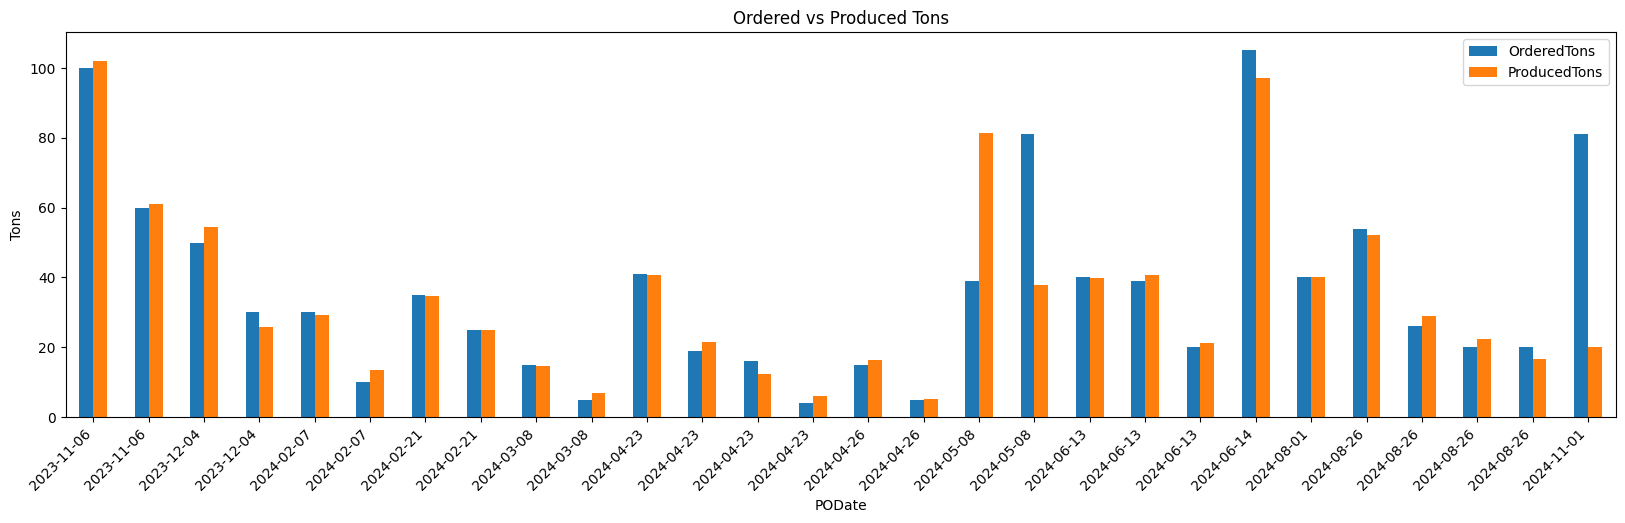

In [129]:
customers = ['American Paper Converting']
since = (pd.Timestamp.now() - pd.DateOffset(months=12)).date()

query = """
SELECT "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons" as "OrderedTons", SUM("LoadTons") AS "ProducedTons", SUM("LoadPieces") AS "ProducedPieces"
FROM "factPOProduction"
WHERE "Customer" IN ({customers})
AND "LoadDate" >= '{since}'
GROUP BY "PONumber", "PODate", "CustomerCode", "Customer", "TotalTons"
ORDER BY "PODate" ASC
""".format(customers=', '.join([f"'{customer}'" for customer in customers]), since=since)
df = read_sql_query(query)

display(df)

df['PODate'] = pd.to_datetime(df['PODate']).dt.date

df.set_index('PODate')[['OrderedTons', 'ProducedTons']].plot(kind='bar', figsize=(20, 5))
plt.title('Ordered vs Produced Tons')
plt.ylabel('Tons')
plt.xticks(rotation=45, ha='right')
plt.show()